In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import igraph as ig
import os
import yaml
from os.path import join
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from scipy.stats import entropy
from scipy import stats
from functools import reduce

import sys
sys.path.insert(1, '..')
from utils import *

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
FIG_SAVE_DIR = join('..', '..', 'figures')
RESULT_SAVE_DIR = join('..', '..', 'results')

### Reading Networks

In [3]:
with open(join('..', '..', 'config.yml')) as f:
    config = yaml.safe_load(f)
    
pwd = config['pwd']
dpath = config['storage']
patterns = config['pattern-data-path']

AREA_NAME = 'NYC'
NETWORK_DIR = join(pwd, dpath, 'Nets', f'{AREA_NAME}-CBG-CBG-Nets')
nets = [(datetime.strptime(f, '%Y-%m-%d'), ig.Graph.Read_Pickle(join(NETWORK_DIR, f))) 
            for f in tqdm(os.listdir(NETWORK_DIR))]
nets = np.array(sorted(nets, key=lambda x: x[0]))

100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [00:29<00:00,  3.69it/s]


### Census Attributes

In [13]:
def mean_time_to_work(row, cols):
    '''
    calculates the mean travel to work time with the help of time categories
    '''
    duration = 0
    w = 0
    for col in cols:
        seg = col.split('-')
        minutes = (int(seg[1]) + int(seg[-1])) / 2
        duration += row[col]*minutes
        w += row[col]
    return duration/w

In [16]:
census_attrs = pd.read_csv(join('..', '..', 'util_datasets', 'census_attributes.csv'))
cbgs = get_CBGS(join('..', '..', 'util_datasets', AREA_NAME, f'{AREA_NAME}-cbgs.json'), dtype=np.int64)
census_attrs = census_attrs[census_attrs['census_block_group'].isin(cbgs)]

commuting_cols = [i for i in census_attrs.columns if i.startswith('t-')]
census_attrs['mean_time_to_work'] = census_attrs.apply(mean_time_to_work, cols=commuting_cols, axis=1)

census_attrs['racial_diversity'] = census_attrs.apply(lambda row: entropy([row['white_population'], row['black_population'], row['asian_population'], row['hispanic_population']]), axis=1)
census_attrs = census_attrs.rename(columns={'median_house_income': 'income'})
census_attrs = census_attrs.rename(columns={'bachelors': 'education'})

col_names = ['income', 'white_population', 'black_population', 'asian_population', 'racial_diversity', 'hispanic_population', 'education', 'mean_time_to_work']
quart = ['Bottom', 'Third', 'Second', 'Top']
for col in col_names:
    census_attrs[f'{col}-quartile'] = pd.qcut(census_attrs[col], q=4, labels=[f'{quart[i]}' for i in range(4)])
    
cattr = census_attrs[['census_block_group', *[f'{cn}-quartile' for cn in col_names]]]
census_attrs_features = census_attrs[['census_block_group', *col_names]]
#census_attrs_features['income'] = census_attrs_features['iincome'].rank(pct=True)

### Income vs Racial Groups

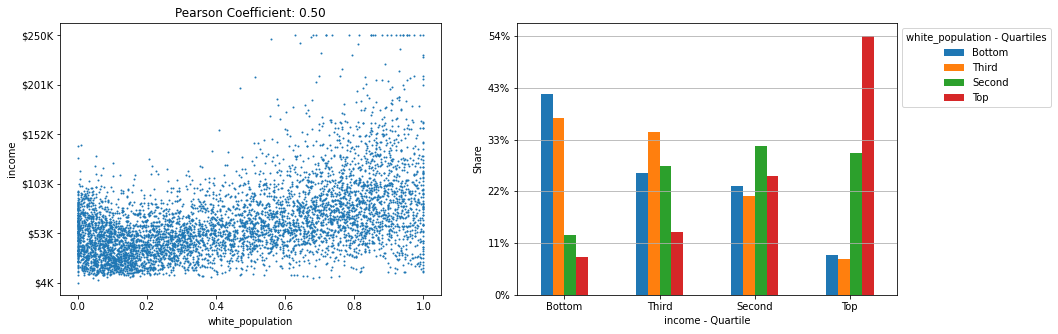

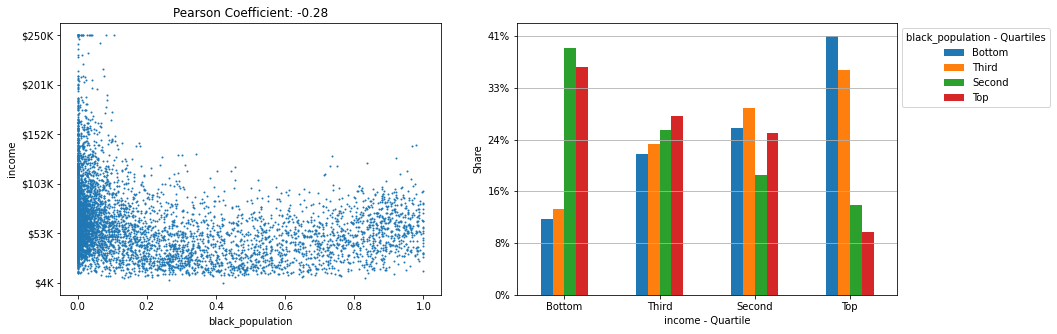

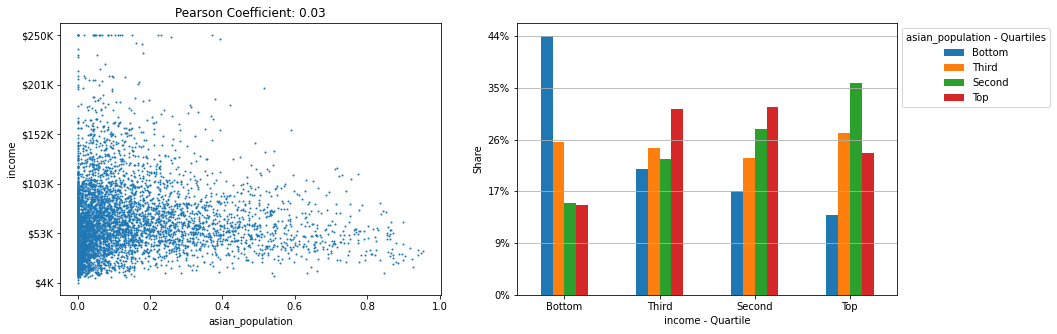

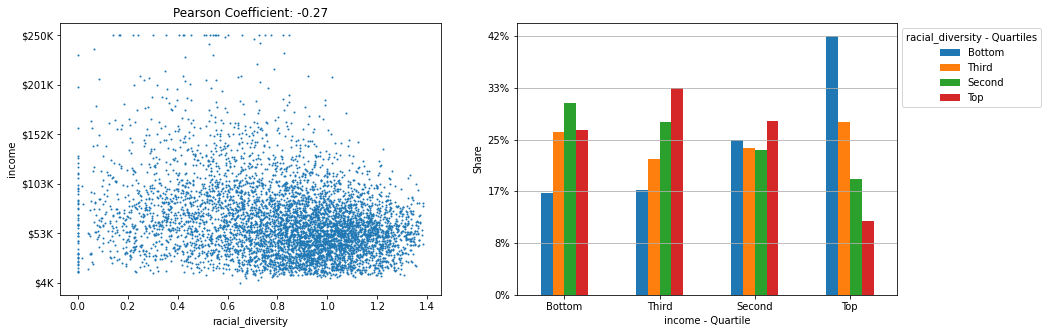

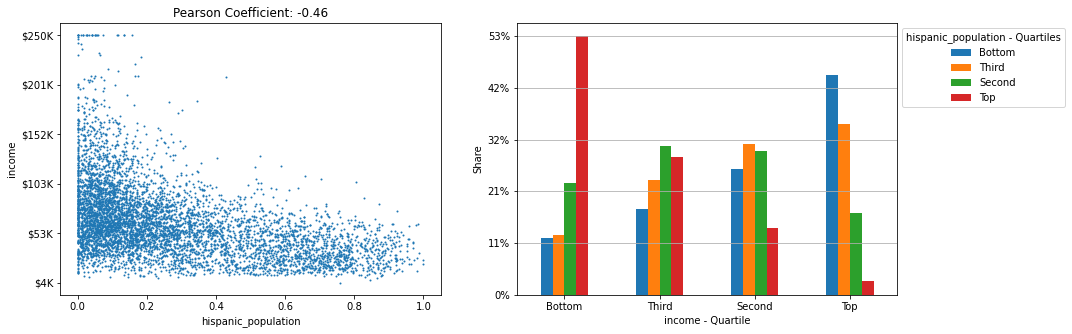

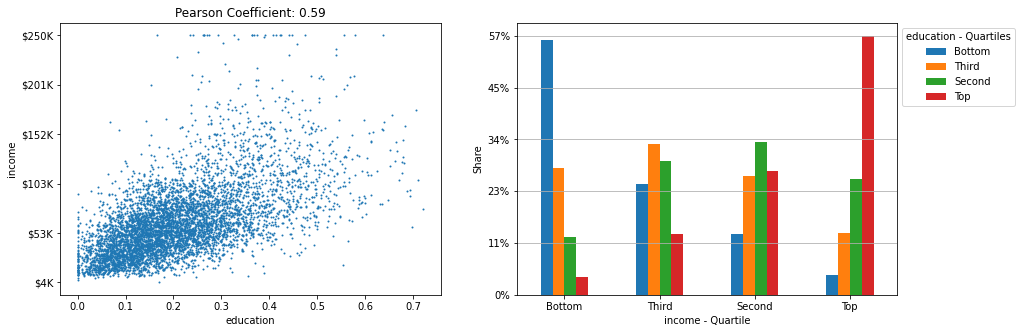

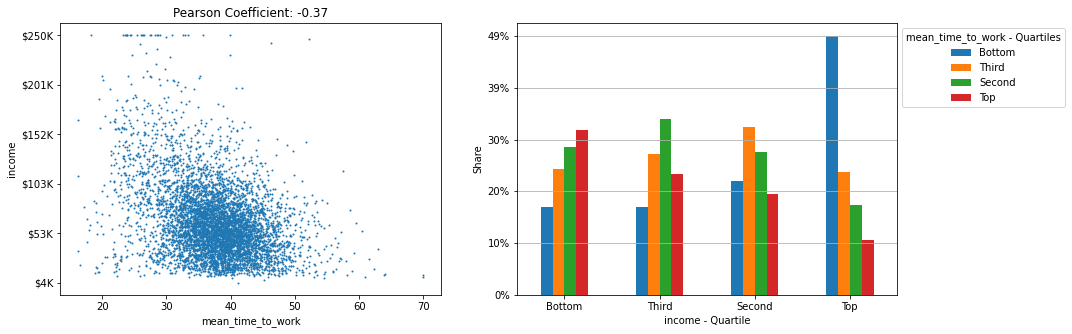

In [17]:
groups = ['white_population', 'black_population', 'asian_population', 'racial_diversity', 'hispanic_population', 'education', 'mean_time_to_work']
for sattr in groups:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].scatter(census_attrs[sattr], census_attrs['income'], s=1)
    axes[0].set_xlabel(sattr)
    axes[0].set_ylabel('income')
    coeff = census_attrs[[sattr, 'income']].corr(method='pearson').values[1,0]
    axes[0].set_title(f'Pearson Coefficient: {coeff:.2f}')

    xr = np.linspace(census_attrs['income'].min(), census_attrs['income'].max(), 6)
    lbl = [f'${x / 1000:.0f}K' for x in xr]
    axes[0].set_yticks(xr)
    axes[0].set_yticklabels(lbl)

    tb = pd.crosstab(census_attrs['income-quartile'], census_attrs[f'{sattr}-quartile'], normalize='index')
    stats.chi2_contingency(tb)
    tb.plot.bar(ax=axes[1], rot=0)
    axes[1].grid(axis='y')
    axes[1].legend(title=f'{sattr} - Quartiles', bbox_to_anchor=(1,1))
    axes[1].set_xlabel('income - Quartile')
    axes[1].set_ylabel('Share')

    yr = np.linspace(0, tb.values.max(), 6)
    lbl = [f'{y*100:.0f}%' for y in yr]
    axes[1].set_yticks(yr)
    axes[1].set_yticklabels(lbl);

    fig.savefig(join(FIG_SAVE_DIR, f'{sattr}-income-corr.png'), bbox_inches='tight');

### Network Summaries

In [18]:
n_edges = []
mean_in_deg = []
mean_out_deg = []
mean_total_deg = []
mean_wdeg = []
diameter = []
clustering_coef = []
mean_path_len = []
for net in tqdm(nets):
    n_edges.append(len(net[1].es))
    mean_in_deg.append(np.nanmean(ig.Graph.degree(net[1], mode='in')))
    mean_out_deg.append(np.nanmean(ig.Graph.degree(net[1], mode='out')))
    mean_total_deg.append(np.nanmean(ig.Graph.degree(net[1], mode='all')))
    mean_wdeg.append(np.nanmean(ig.Graph.degree(net[1], mode='all')) / len(net[1].vs))
    diameter.append(ig.Graph.diameter(nets[0][1], directed=True, unconn=net[1].is_connected()))
    clustering_coef.append(ig.Graph.transitivity_undirected(net[1]))
    mean_path_len.append(ig.Graph.average_path_length(net[1], directed=True, unconn=net[1].is_connected()))

100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [05:03<00:00,  2.83s/it]


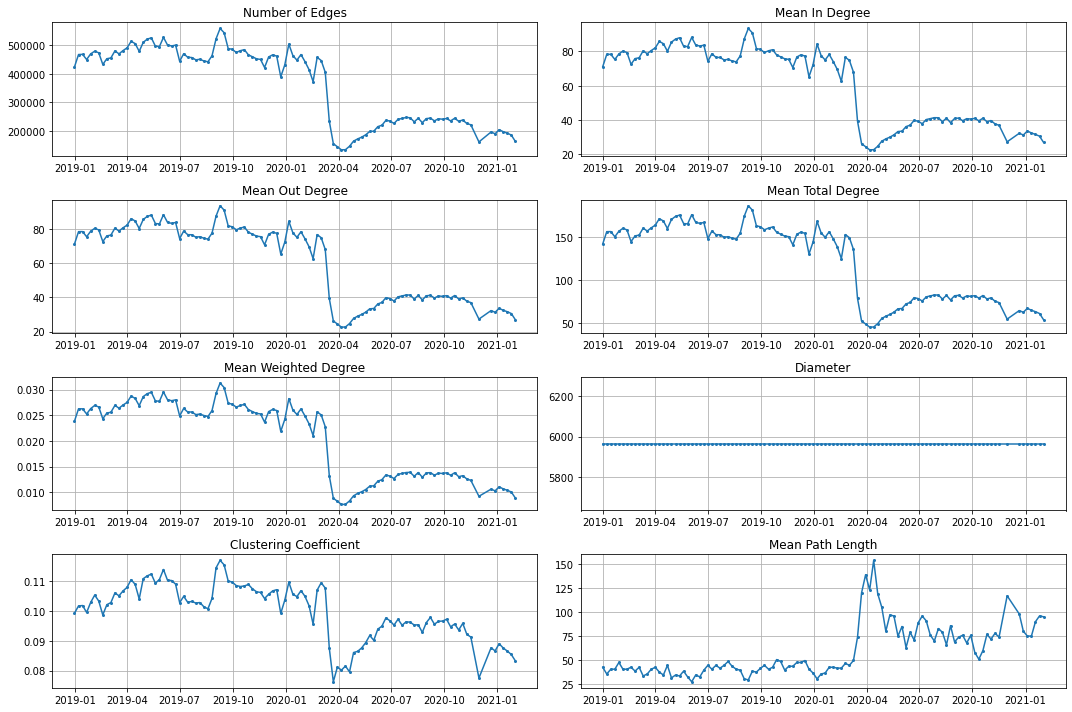

In [19]:
fig, axes = plt.subplots(4, 2, figsize=(15, 10))

arrays = [
    (n_edges, 'Number of Edges'),
    (mean_in_deg, 'Mean In Degree'),
    (mean_out_deg, 'Mean Out Degree'),
    (mean_total_deg, 'Mean Total Degree'),
    (mean_wdeg, 'Mean Weighted Degree'),
    (diameter, 'Diameter'),
    (clustering_coef, 'Clustering Coefficient'),
    (mean_path_len, 'Mean Path Length'),
]

# time steps
dx = [net[0] for net in nets]

for i, ax in enumerate(axes.flatten()):
    ax.plot(dx, arrays[i][0], marker='o', markersize=2)
    ax.set_title(arrays[i][1])
    ax.grid()
    
plt.tight_layout()
plt.savefig(join(FIG_SAVE_DIR, f'{AREA_NAME}-net-summary.png'), bbox_to_inches='tight')

### Temporal Change in Centrality Metrics by Demographic Groups 

In [20]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [21]:
def change_sign(val):
    '''
    returns the sign of the change
    '''
    if np.abs(val) <= 0.5:
        return 'neutral'
    elif val > 0:
        return 'positive'
    else:
        return 'negative'

In [22]:
def get_metric_change_df(t1, t2, attribute_df):
    '''
    calculates the centrality metrics and assings the values to the CBGs
    at the end, merges with the provided attribute df
    '''
    cent_metrics = [
        ('Closeness', ig.Graph.closeness, {'cutoff': -1, 'normalized': True}), 
        ('Betweenness', ig.Graph.betweenness, {'cutoff': -1, 'directed': True}), 
        ('Eigenvector', ig.Graph.eigenvector_centrality, {'directed': True, 'scale': True})
    ]

    ts_source = datetime.strptime(t1, '%Y-%m-%d')
    ts_target = datetime.strptime(t2, '%Y-%m-%d')

    net_source = nets[nets[:, 0] == ts_source][0,1]
    net_target = nets[nets[:, 0] == ts_target][0,1]
    
    dfs = []
    for cent_metric_name, cent_metric, params in cent_metrics:
        source_vals = np.array(cent_metric(net_source, **params))
        target_vals = np.array(cent_metric(net_target, **params))

        source_data = {
            'source_value': source_vals,
            'CBG': net_source.vs['name']
        }

        target_data = {
            'target_value': target_vals,
            'CBG': net_target.vs['name']
        }

        source_df = pd.DataFrame(source_data)
        target_df = pd.DataFrame(target_data)

        r = pd.merge(source_df, target_df, on="CBG", how='inner')
        r[f'{cent_metric_name}_relative_change'] = (r['target_value'] - r['source_value']) / r['source_value'] * 100
        r[f'{cent_metric_name}_change_sign'] = r[f'{cent_metric_name}_relative_change'].apply(change_sign)
        r['CBG'] = r['CBG'].astype(np.int64)
        d = pd.merge(attribute_df, r, left_on='census_block_group', right_on='CBG', how='inner')
        dfs.append((cent_metric_name, d))
        
    return dfs

### Regression Model btw Relative Centrality Changes & Demographical Attributes 

#### Between Two Dates

In [23]:
t1 = '2020-01-13'
t2 = '2020-06-08'
dfs = get_metric_change_df(t1, t2, census_attrs_features)

In [24]:
features = ['income', 'white_population', 'black_population', 'asian_population', 'hispanic_population', 'education', 'mean_time_to_work']

for metric_name, df in dfs:
    df = df.dropna()
    
    res = sm.OLS(df[f'{metric_name}_relative_change'], df[features]).fit()
    with open(join(RESULT_SAVE_DIR, f'{metric_name}-{t1}-{t2}-ols-results-income-excluded.txt'), 'w') as f:
        f.write(res.summary().as_text())

#### Average of Jan-Feb-March & Apr-May-Jun

In [25]:
# Jan-Feb-March & Apr-May-Jun networks
grouped_nets = nets[(nets[:, 0] >= datetime(2020, 1, 1)) & (nets[:, 0] < datetime(2020, 7, 1))]
# first case
mid = np.where(grouped_nets[:, 0] == datetime(2020, 3, 9))[0][0]

# find the cbgs that exists in all networks
cbgs = []
for ind in range(len(grouped_nets)):
    cbgs.append(grouped_nets[ind, 1].vs['name'])
    
cbgs = reduce(np.intersect1d, cbgs)
cbg_attrs = census_attrs_features.set_index('census_block_group').loc[cbgs.astype(np.int64)].dropna()
cbgs = cbg_attrs.index.values.astype(str)

In [40]:
features = ['income', 'white_population', 'black_population', 'asian_population', 'racial_diversity', 'hispanic_population', 'education', 'mean_time_to_work']

cent_metrics = [
    ('Closeness', ig.Graph.closeness, {'cutoff': 3, 'normalized': True}), 
    ('Betweenness', ig.Graph.betweenness, {'cutoff': 3, 'directed': True}), 
    ('Eigenvector', ig.Graph.eigenvector_centrality, {'directed': True, 'scale': True}),
    ('In-Degree', 'in', None),
    ('Out-Degree', 'out', None),
    ('Total-Degree', 'all', None)
    #('In-Visits', None, None),
    #('Out-Visits', None, None)
]

for cent_metric_name, metric, params in cent_metrics:
    net_dfs = []
    for timestamp, net in tqdm(grouped_nets):
        if not isinstance(metric, str) and params:
            values = np.array(metric(net, **params))
        elif isinstance(metric, str) and not params:
            values = net.degree(mode=metric)
        else:
            values = net.vs['visits']
        data = {
            'value': values,
            'CBG': net.vs['name']
        }
        net_df = pd.DataFrame(data).set_index('CBG')
        net_dfs.append(net_df.loc[cbgs, 'value'].values)

    net_dfs = np.array(net_dfs)
    # Jan-Feb-March
    g1 = net_dfs[:mid]
    mean_vals_g1 = g1.mean(axis=0)
    # Apr-May-Jun
    g2 = net_dfs[mid:]
    mean_vals_g2 = g2.mean(axis=0)

    # compute relative change
    rel_chg = (mean_vals_g2 - mean_vals_g1) / mean_vals_g1 * 100

    res = sm.OLS(pd.Series(rel_chg, name=f'{cent_metric_name} Relative Change, Jan-Feb-March vs Apr-May-Jun', index=cbg_attrs.index), cbg_attrs[features]).fit()
    with open(join(RESULT_SAVE_DIR, f'{cent_metric_name}-ols-results-three-months.txt'), 'w') as f:
        f.write(res.summary().as_text())

100%|█████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 226.69it/s]


### Centrality Metric Changes per Demographic Groups

In [29]:
def plot_change_in_metrics_by_demo_groups(df, metric_name, mode, t1, t2, normalize='index'):
    '''
    plots the centrality metric changes with two options:
        - quartile frequencies
        - mean relative change
        
    normalizes by quartiles (columns) or change in metrics (index)
    '''
    top_color = "#d7191c"
    neutral_color = '#fdb863'
    bottom_color = "#2c7bb6"

    fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True)
    axes = axes.flatten()

    cols = [col for col in cattr.columns if '-quartile' in col]
    for ind, attr in enumerate(cols):

        ax = axes[ind]

        pd.crosstab(df[attr], df[f'{metric_name}_{mode}'], normalize=normalize).plot.barh(ax=ax, )

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Demographic Group')
        ax.set_title(f"{attr.split('-')[0]}")

    xlocs = np.linspace(0, 1, 5)
    lbl = [f"{loc*100:.0f}%" for loc in xlocs]

    for ax in axes:
        ax.set_xticks(xlocs)
        ax.set_xticklabels(lbl)
        ax.grid(axis='x', color='white')

    top_patch = mpatches.Patch(color='white')
    neutral_patch = mpatches.Patch(color='white')
    bottom_patch = mpatches.Patch(color='white')
    
    fig.legend([top_patch, neutral_patch, bottom_patch],
                       [f'Positive ({df[df[f"{metric_name}_{mode}"] == "positive"].shape[0]} CBGs)', 
                        f'Neutral ({df[df[f"{metric_name}_{mode}"] == "neutral"].shape[0]} CBGs)', 
                        f'Negative ({df[df[f"{metric_name}_{mode}"] == "negative"].shape[0]} CBGs)'],
                       loc="center",
                       ncol=3,
                       bbox_to_anchor=(0.5, 1.05), 
                       title_fontsize=15,
                       title=f"{metric_name} Centrality Change in Quartiles per Demographic Groups, {t1}/{t2}", 
                       edgecolor="white")

    plt.tight_layout()
    fig.savefig(join(FIG_SAVE_DIR, f"{metric_name}-{mode}-{normalize}-{t1}-{t2}.png"), bbox_inches="tight")

In [30]:
t1 = '2020-01-13'
t2 = '2020-05-11'
qdfs = get_metric_change_df(t1, t2, cattr)

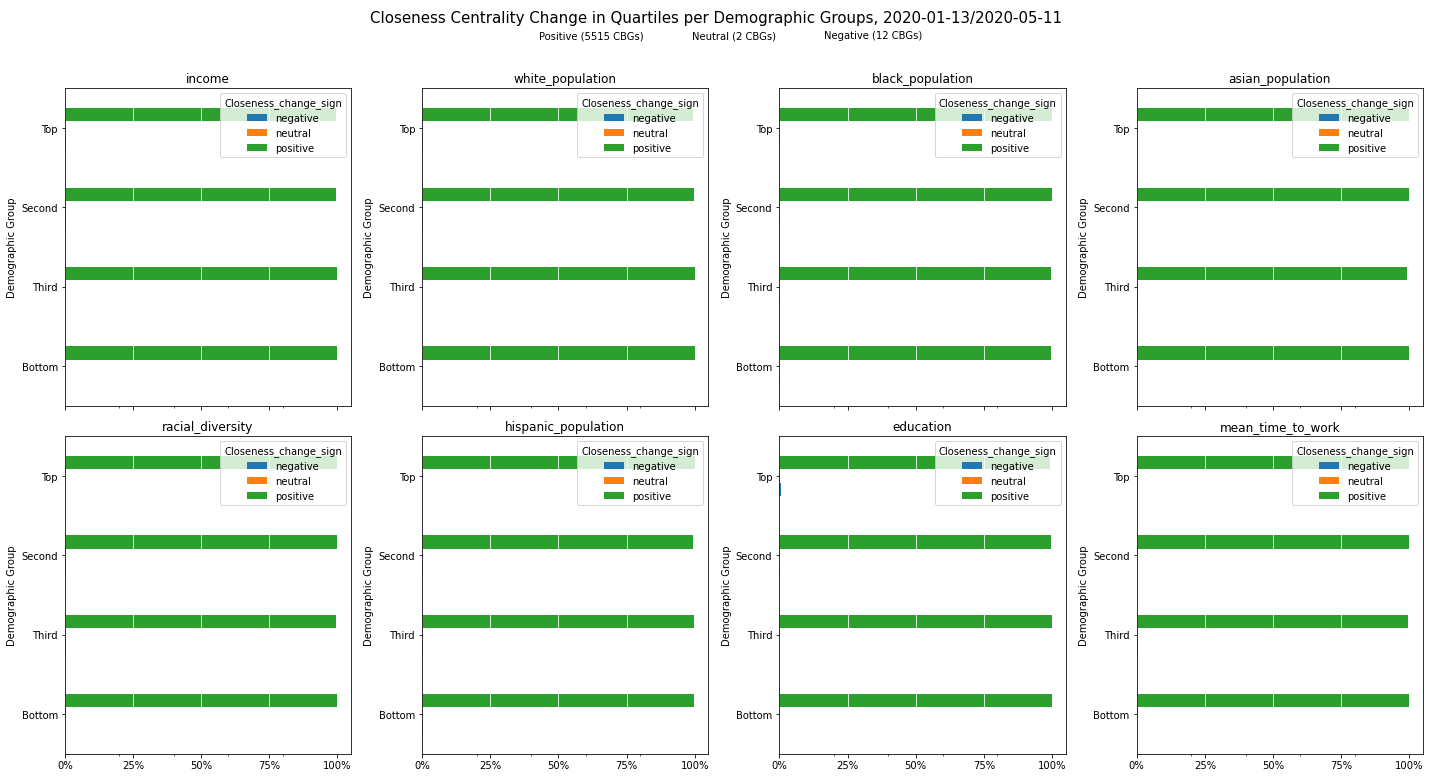

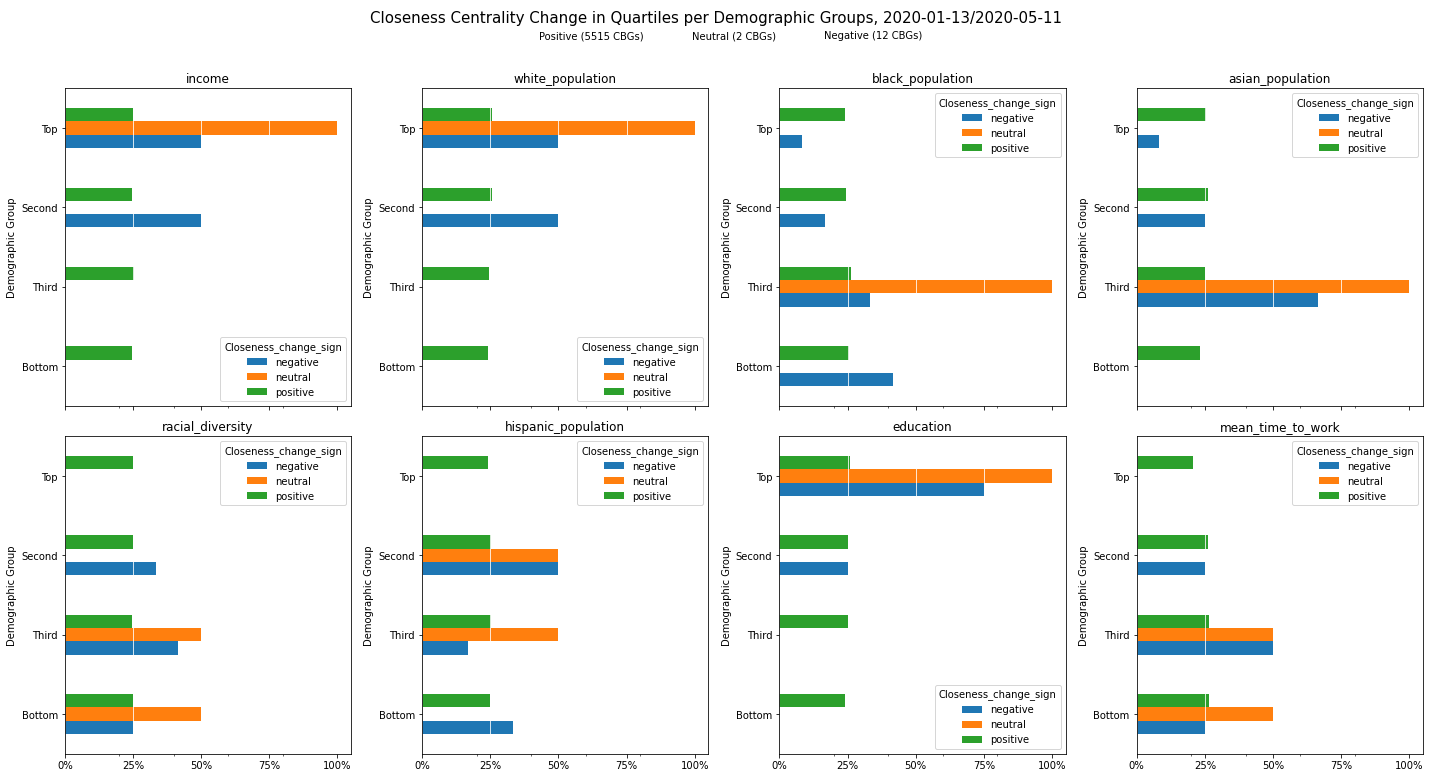

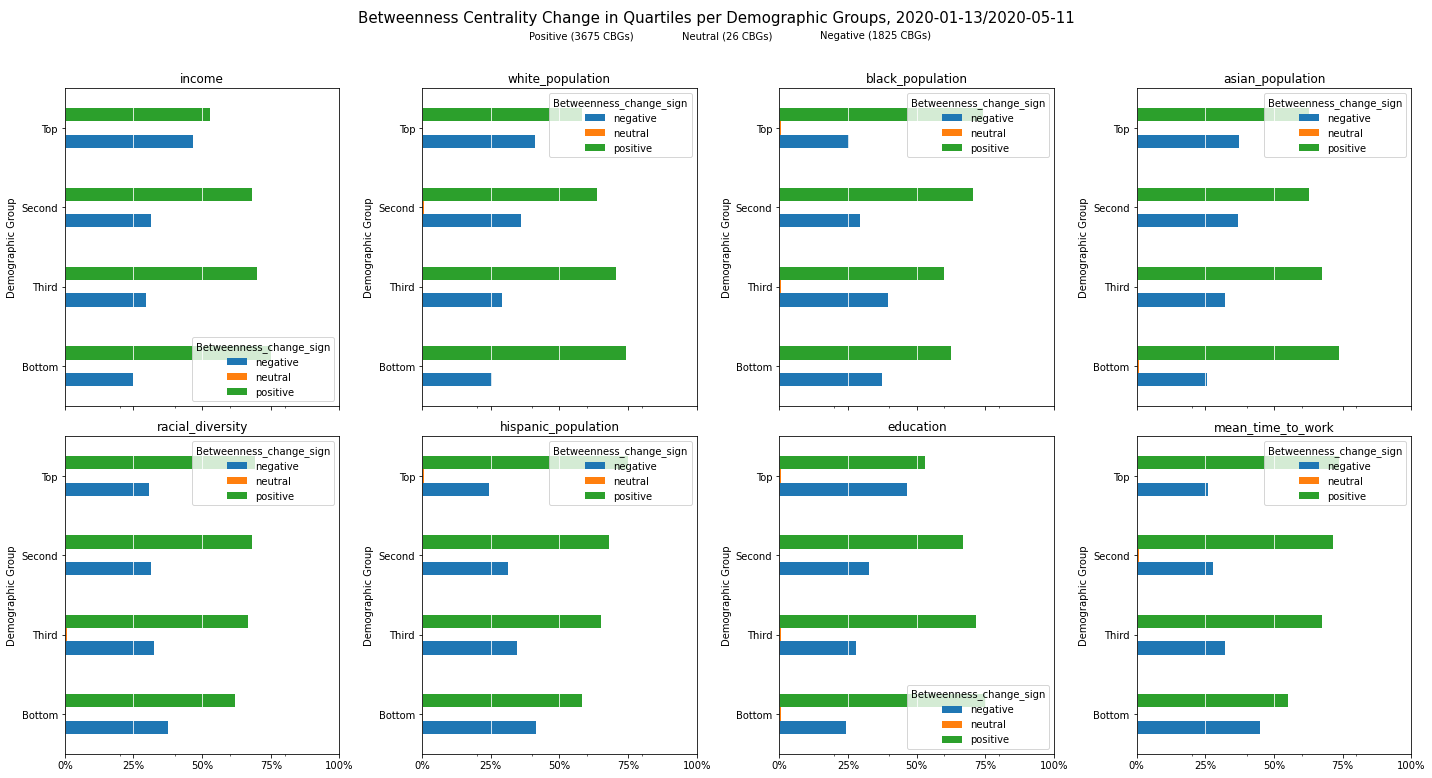

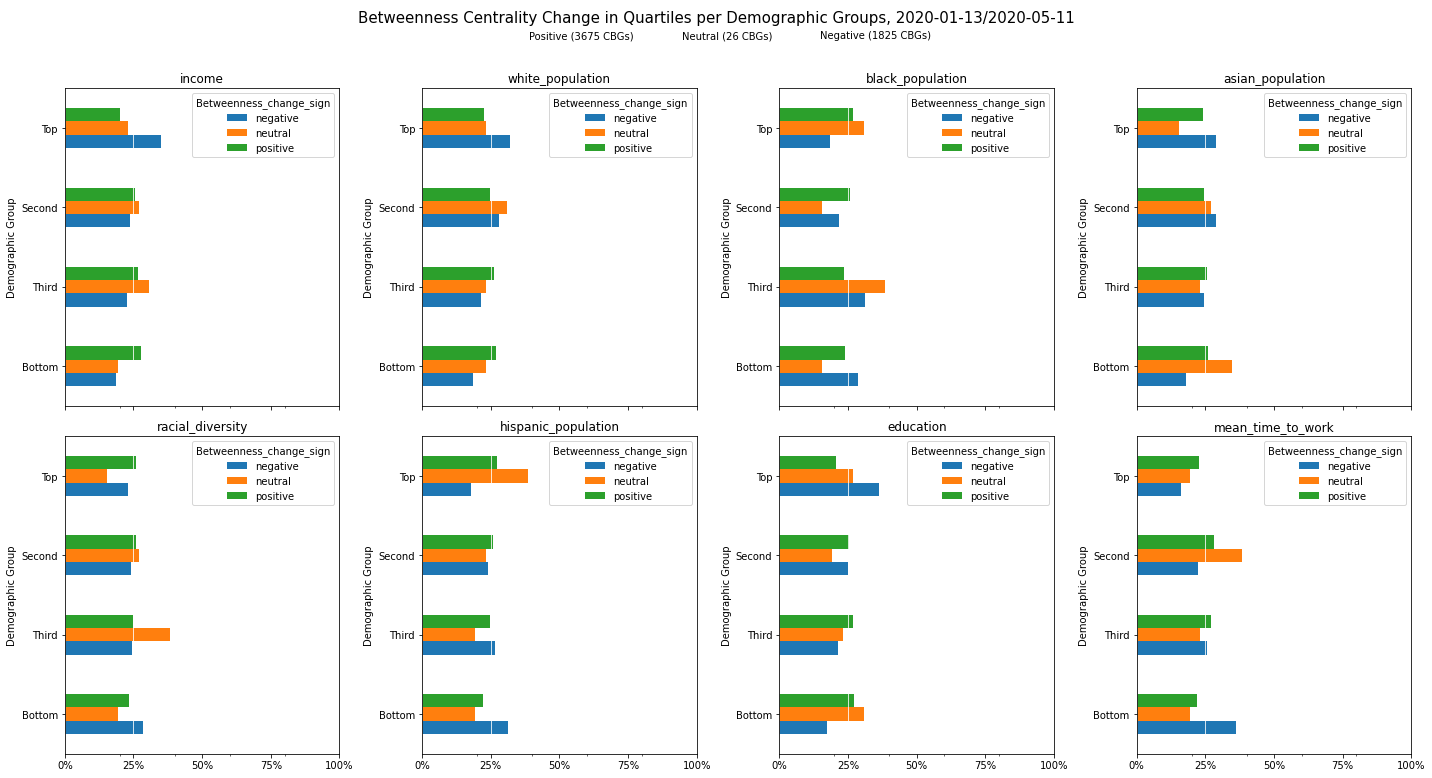

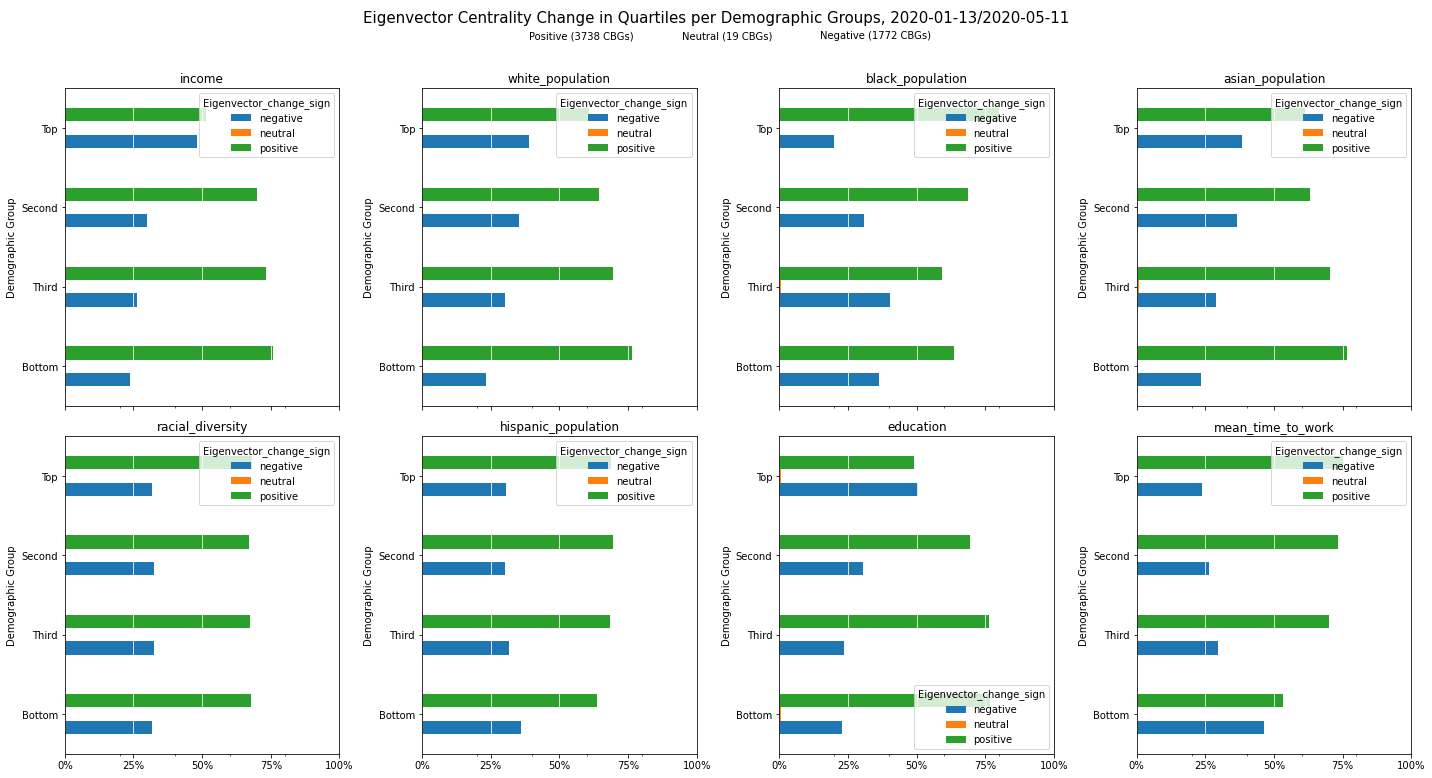

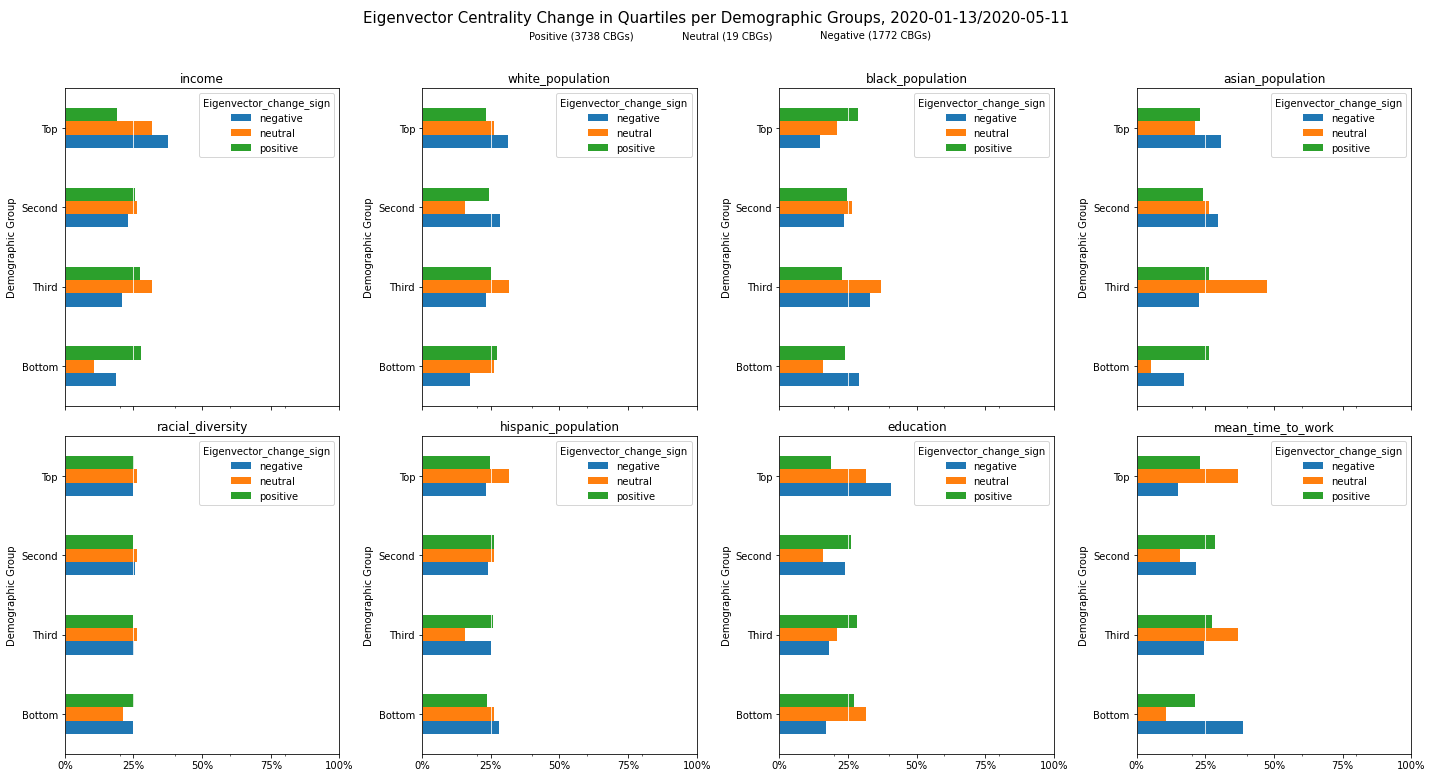

In [31]:
for metric_name, df in qdfs:
    df = df.dropna()
    for mode in ['index', 'columns']:
        plot_change_in_metrics_by_demo_groups(df, 
                                              metric_name, 
                                              'change_sign', 
                                              t1, 
                                              t2, 
                                              normalize=mode)